***MODEL EVALUATION***

Now that we've trained the network with different configurations and learning rates

In [1]:
#Let's first load all the libraries we need

from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop, Adamax
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
#import imgaug as ia
from tqdm import tqdm
#from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import pickle
import os, cv2
#from preprocessing import parse_annotation, BatchGenerator


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
#Last step would be to train the model, defining the batchsize and the epochs
#model.fit(X, y, batch_size=32, epochs=26)
train_df = pd.read_csv('/home/martar/notebooks/Unipart Project/Final Project/preprocessed_data/train_labels.csv', index_col="filename")
test_df = pd.read_csv('/home/martar/notebooks/Unipart Project/Final Project/preprocessed_data/test_labels.csv', index_col="filename")


In [ ]:
read_path = ['/home/martar/notebooks/Unipart Project/Final Project/melanoma/preprocessed_data/', '/home/martar/notebooks/Unipart Project/Final Project/notmelanoma/preprocessed_data/']

function = lambda x: read_path[1] if 'notmelanoma' in x else read_path[0]

train_df["readpath"] = train_df["class"].apply(function)
test_df["readpath"] = test_df["class"].apply(function)

del train_df["path_name"]
del test_df["path_name"]

In [ ]:
from skimage.io import imread
from skimage.transform import rotate, resize
image_size = (192,192)

X = [None]*train_df.shape[0]
y = [None]*train_df.shape[0]

X_test = [None]*test_df.shape[0]
y_test = [None]*test_df.shape[0]

#We need to normalised the images that we input into the model

#Since 255 is the maximin pixel value. Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1]. And the benefits are:

#QUESTION - DOES LIST APPEND PRESERVE THE ORDER?
columns_output = ['xmin_norm', 'ymin_norm', 'box_width', 'box_height']

for index,file in enumerate(train_df.index.values):
 
    X[index] = imread(train_df["readpath"][index]+file)/255
    y[index] = train_df[columns_output].loc[file]

#As neural networks use arrays as inputs
X = np.array(X)
y = np.array(y)


for index,file in enumerate(test_df.index.values):
 
    X_test[index] = imread(test_df["readpath"][index]+file)/255
    y_test[index] = test_df[columns_output].loc[file]

#As neural networks use arrays as inputs
X_test = np.array(X_test)
y_test = np.array(y_test)



In [ ]:
#Now that we've removed the early stopping and gone for 150 epochs, we really need to visualise the history to understand what is happening
#When the model is overfiting and so on.

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'mean_absolute_error' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'mean_absolute_error' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training MAE (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation MAE (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [63]:
def plot_example(img, bbox):
    plt.imshow(img)
    plt.plot([bbox[1], bbox[1], bbox[1] + bbox[3], bbox[1] + bbox[3], bbox[1]],
         [bbox[0], bbox[0] + bbox[2], bbox[0] + bbox[2], bbox[0], bbox[0]], 'r')
    plt.axis('off')
    plt.show();

In [ ]:
def intersection(a, b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0] + a[2], b[0] + b[2]) - x
    h = min(a[1] + a[3], b[1] + b[3]) - y
    if w < 0 or h < 0:
        return 0
    return w * h

def union(a, b):
    return a[2] * a[3] + b[2] * b[3] - intersection(a, b)

def iou(y_true, y_pred):
    return intersection(y_true, y_pred) / union(y_true, y_pred)

In [ ]:
#custom to us are the labels and the image size
LABELS = ['melanoma', 'notmelanoma']

    #I originally tried 200 * 200 and gave me an error - this is because the input layer is a 32 neuron so we need multiples of 32
#I'm going to use 32*7 = 224

IMAGE_H, IMAGE_W = 192, 192
#Grids are used when you are facing problems with more than one object to detect and the fact they alow 2 (in the original)
#overlapping bouding boxes. In our case, we have only 1 very well defined object to detect so we don't need more than 1 grid 

#GRID_H,  GRID_W  = 7 , 7

#Let's leave the rest as is

BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [ ]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [2]:
#Now we have to load the models we saved
from keras.models import load_model

#adam_lr0001 = load_model('adam_lr0001.h5', custom_objects={
   # 'tf':tf})
adam_lr0001_dropout = load_model('adam_lr0001_dropout.h5',custom_objects={
    'tf':tf})
#adam_lrexp05 = load_model('adam_lrexp05.h5',custom_objects={
   # 'tf':tf})
#adamax = load_model('adamaxlr0002.h5',custom_objects={
   # 'tf':tf})
#RMS = load_model('RMSprop.h5',custom_objects={
   # 'tf':tf})
#SGD = load_model('SGDlr001.h5',custom_objects={
   # 'tf':tf})


In [3]:
def get_mean_iou(model, X, y):
    for i in range(y.shape[0]):
        ye = model.predict(X[i:i+1, :, :, :])
        all_iou[i] = iou(y[i, :], ye[0, :])
    return all_iou.mean()

In [4]:
#model_list = [adam_lr0001, adam_lr0001_dropout, adam_lrexp05, adamax, RMS, SGD]
model_list = [adam_lr0001_dropout]
#optimiser_name = ['adam', 'adam_dropout', 'adam', 'adamax', 'RMS', 'SGD']
optimiser_name = ['adam_dropout']
#lr = [0.001, 0.001, 1e-5, 0.002, 0.001, 0.001]
lr = [0.001]

In [5]:
avg_iou = [None]*len(model_list)
avg_iou_test = [None]*len(model_list)
for index, model in enumerate(model_list):
    avg_iou[index] = get_mean_iou(model, X, y)
    avg_iou_test[index] = get_mean_iou(model, X_test, y_test)

NameError: name 'X' is not defined

In [ ]:
train_metrics = [None]*len(model_list)
test_metrics= [None]*len(model_list)
for index, model in enumerate(model_list):
    train_metrics[index] = model.evaluate(X, y, batch_size=32)
    test_metrics[index] = model.evaluate(X_test,y_test,batch_size=32)


In [ ]:
mse

In [ ]:
metrics_dic = {"optimiser": optimiser_name,
              "learning_rate": lr,
              "metrics": 'mse,mae',
              "train_metrics":train_metrics,
              "test_metrics": test_metrics,
               "iou_train": avg_iou,
               "iou_test":avg_iou_test             
              }

metrics_df = pd.DataFrame(metrics_dic)

In [ ]:
metrics_df.to_csv("/home/martar/notebooks/Unipart Project/Final Project/evaluation_summary.csv")

In [ ]:
metrics_df.head()

In [ ]:
all_iou = np.zeros((np.shape(y)[0],))
for i in range(40): # np.shape(X)[0]): 
    ye = adam_lr0001_dropout.predict(X[i:i+1, :, :, :])
    plot_example(X[i,:,:,:], ye[0, :]*192)
    all_iou[i] = iou(y[i, :], ye[0, :])

In [ ]:
all_iou = np.zeros((np.shape(y)[0],))
for i in range(42): 
    ye = adam_lr0001_dropout.predict(X_test[i:i+1, :, :, :])
    plot_example(X_test[i,:,:,:], ye[0, :]*192)
    all_iou[i] = iou(y_test[i, :], ye[0, :])

In [45]:
imread?

In [60]:
from skimage.io import imread
from skimage.transform import rotate, resize
images = os.listdir('/home/martar/notebooks/Unipart Project/Final Project/Generalisation')
images = images[1:4]
shape = (192,192)
X_gen = [None]*len(images)

for index, image in enumerate(images):
    X_gen[index] = resize(imread('/home/martar/notebooks/Unipart Project/Final Project/Generalisation/'+image),shape)
X_gen = np.array(X_gen)



/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [61]:
images

['melanoma_general.jpg', 'melanoma_occlussion.jpg', 'PastedGraphic-1.jpg']

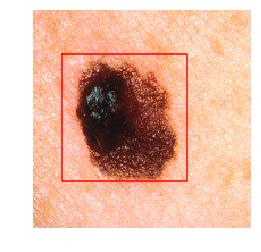

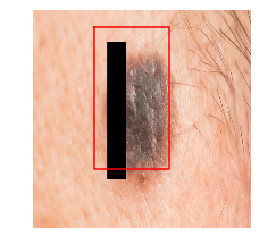

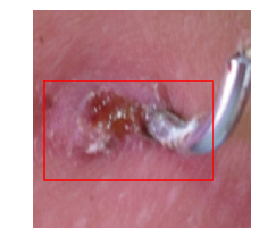

In [65]:
#all_iou = np.zeros((np.shape(y)[0],))
for i in range(3): # np.shape(X)[0]): 
    ye = adam_lr0001_dropout.predict(X_gen[i:i+1, :, :, :])
    plot_example(X_gen[i,:,:,:], ye[0, :]*192)
    